In [4]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate


#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model


#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.21.5
Skimage      : 0.19.2
Scikit-learn : 1.0.2
Tensorflow   : 2.11.1


In [5]:
! pip install graphviz
! pip install pydot
!pip install pydotplus

## Loading data

**Paths to data**

In [6]:
topDir = './'  
print(os.listdir(os.path.join(topDir, 'cnn_data')))  #see what's in the input folder (where data is in)
train_X_path = os.path.join(topDir, 'cnn_data/cnn_train_X')  
train_Y_path = os.path.join(topDir, 'cnn_data/cnn_train_Y')  
test_X_path = os.path.join(topDir, 'cnn_data/cnn_test_X')  
test_Y_path = os.path.join(topDir, 'cnn_data/cnn_test_Y')  

['cnn_test_X', 'cnn_test_Y', 'cnn_train_X', 'cnn_train_Y']


In [7]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (256,256)  #Default to (256,266), use (None,None) if you do not want to resize imgs

**Load training and test data (noisy images)**

In [8]:
%%time
# Get training data
def get_images(path, output_shape=(None, None)):
    
    # Load the images as a 4D numpy array
    X_data = skimage.io.imread_collection(os.path.join(path, '*.png')).concatenate()
    return X_data


X_train = get_images(train_X_path, output_shape=(img_height,img_width))
X_test = get_images(test_X_path, output_shape=(img_height,img_width))

print("X_train",X_train.shape, X_train.dtype)
print("X_test",X_test.shape, X_test.dtype)    


X_train (84, 256, 256) uint8
X_test (5, 256, 256) uint8
Wall time: 357 ms


**Load labeled data (denoised images)**

In [10]:
%%time
# Get training data labels
def get_labels(path, output_shape=(None, None)):
    
    # Load the images as a 4D numpy array
    Y_data = skimage.io.imread_collection(os.path.join(path, '*.png')).concatenate()    
    return Y_data    
    
Y_train = get_labels(train_Y_path, output_shape=(img_height,img_width))
Y_test = get_labels(test_Y_path, output_shape=(img_height,img_width))
print("We have {} labeled images (train) of size ({},{}) and type {}".format(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],Y_train.dtype))
print("We have {} labeled images (test) of size ({},{}) and type {}".format(Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],Y_test.dtype))



We have 84 labeled images (train) of size (256,256) and type uint8
We have 6 labeled images (test) of size (256,256) and type uint8
Wall time: 173 ms


**Visualize data**

Looking at image  51


Text(0.5, 1.0, 'image denoised')

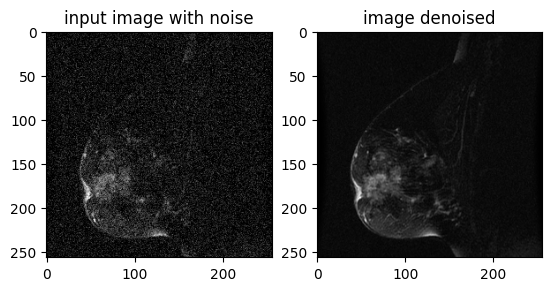

In [11]:
%matplotlib inline

idx = np.random.randint(Y_train.shape[0], size=1)[0]
X_train = X_train.squeeze()
Y_train = Y_train.squeeze()

print ('Looking at image ', idx)
plt.subplot(1,2,1)
plt.imshow(X_train[idx, :, :] ,cmap='gray')
plt.title('input image with noise')

plt.subplot(1,2,2)
plt.imshow(Y_train[idx, :, :],cmap='gray')
plt.title('image denoised')
    

## Preprocessing

In [14]:
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

X_train_nd = X_train.copy()

def normalizing_data(X_train):
    
    X_train_nd = np.zeros(X_train.shape)
    
    for idx in range(X_train.shape[0]) : 

        # Define the box-car kernel
        input_img = X_train[idx, :, :]
        kernel_size = 6
        kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)

        # Apply the kernel to the input image using 2D convolution
        local_mean_map = convolve2d(input_img, kernel, mode='same')

        # Compute the local variance using a Gaussian filter
        local_var_map = gaussian_filter(input_img ** 2, kernel_size) - local_mean_map ** 2
        # Add a small positive constant to the variance to prevent taking the square root of a negative value 
        eps = sys.float_info.epsilon
        local_var_map = np.maximum(local_var_map, eps)
        # Compute the local standard deviation by taking the square root of the variance
        local_std_map = np.sqrt(local_var_map)

        # Normalize the input volume
        X_train_nd[idx, :,:] = (input_img - local_mean_map) / local_std_map

        # Normalize the output volume (assuming it's also stored as a numpy array)
        #normalized_output = (output_img - local_mean_map) / local_std_map
        
        return X_train_nd, local_mean_map,local_std_map

In [16]:
#crating patches to feed the CNN
def create_patches(X_data, patch_size):

    overlap = patch_size//2
    # extract patches with overlap
    patches = []
    for i in range(len(X_data)):
        img = X_data[i,:,:]
        for j in range(0, img.shape[0] - patch_size + 1, overlap):
            for k in range(0, img.shape[1] - patch_size + 1, overlap):
                patch = img[j:j+patch_size, k:k+patch_size]
                patches.append(patch.reshape(patch_size, patch_size, 1))

    patches = np.array(patches)
    return patches

patch_size = 12
X_train,_,_ = normalizing_data(X_train)
Y_train,_,_ = normalizing_data(Y_train)
X_patches = create_patches(X_train, patch_size)
Y_patches = create_patches(Y_train, patch_size)
X_val_patches = create_patches(X_test, patch_size)
Y_val_patches = create_patches(Y_test, patch_size)

print(X_patches.shape)
print(Y_patches.shape)
print(X_train.shape)
print(Y_train.shape)

(141204, 12, 12, 1)
(141204, 12, 12, 1)
(84, 256, 256)
(84, 256, 256)


## Defining the architecture

In [17]:
import argparse
import re
import os, glob, datetime
import numpy as np
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
import keras.backend as K

# if required reload the model
def DnCNN(depth,filters=64,image_channels=1, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))
    # 1st layer, Conv+relu
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
    # depth-2 layers, Conv+BN+relu
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            #x = BatchNormalization(axis=3, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x) 
        x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        layer_count += 1
        x = Activation('relu',name = 'relu'+str(layer_count))(x)  
    # last layer, Conv
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    
    return model

model = DnCNN(depth = 17,filters=64,image_channels=1, use_bnorm=True)
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png')
model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input0 (InputLayer)            [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   640         ['input0[0][0]']                 
                                64)                                                               
                                                                                                  
 relu2 (Activation)             (None, None,

                                64)                                                               
                                                                                                  
 conv27 (Conv2D)                (None, None, None,   36864       ['relu26[0][0]']                 
                                64)                                                               
                                                                                                  
 bn28 (BatchNormalization)      (None, None, None,   256         ['conv27[0][0]']                 
                                64)                                                               
                                                                                                  
 relu29 (Activation)            (None, None, None,   0           ['bn28[0][0]']                   
                                64)                                                               
          

## Training

In [ ]:
# Fit model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 300

batch_size = 100

history = model.fit(X_patches, Y_patches,batch_size=batch_size,epochs=epochs)

## Predictions

In [18]:
## Here is teh pretrained model to avoid long training time
model.load_weights('model.h5')
predictions = model.predict(X_patches )
print(predictions.shape)

4413/4413 [==============================] - 290s 66ms/step
(141204, 12, 12, 1)


 ## Output

In [132]:
import numpy as np

##putting the output patches of the CNN together to reconstruct the image
def reconstruct_images_from_patches(patches, image_shapes, patch_size):
    num_patches_per_row = (image_shapes[0] - patch_size) // (patch_size // 2) + 1
    num_patches_per_col = (image_shapes[1] - patch_size) // (patch_size // 2) + 1
    num_patches_per_image = num_patches_per_row * num_patches_per_col
    num_images = patches.shape[0] // num_patches_per_image
    images = np.zeros((num_images, image_shapes[0], image_shapes[1], image_shapes[2]))
    idx = 0
    for i in range(num_images):
        img = np.zeros((image_shapes[0], image_shapes[1], image_shapes[2]))
        for j in range(num_patches_per_row):
            for k in range(num_patches_per_col):
                patch = patches[idx].reshape(patch_size, patch_size, image_shapes[2])
                row_start = j * (patch_size // 2)
                col_start = k * (patch_size // 2)
                img[row_start:row_start+patch_size, col_start:col_start+patch_size, :] += patch
                idx += 1
        img /= 4  # average overlapping regions
        images[i] = img
    return images



Text(0.5, 1.0, 'ground truth image')

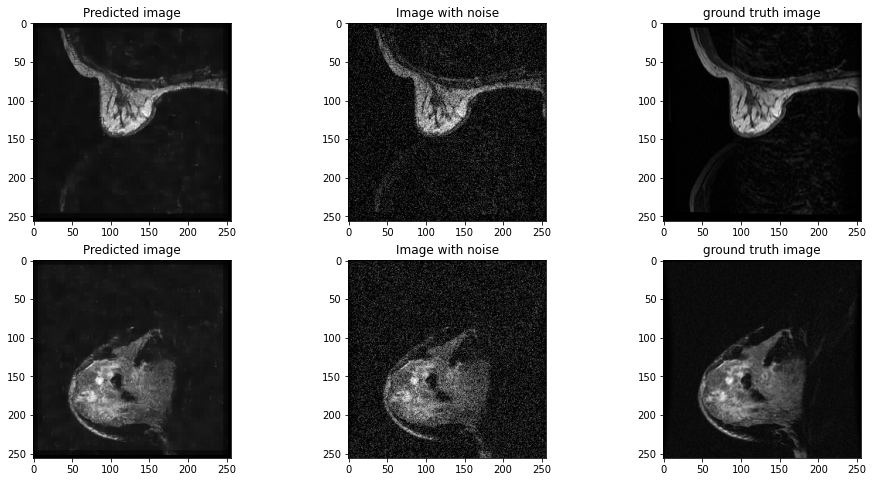

In [155]:
X_pred = reconstruct_images_from_patches(predictions, (256,256,1), 12)
X_pred = X_pred.squeeze()

#X_pred = (X_pred+mean)*std
idx = 2
plt.figure(figsize=(16, 8)) 
plt.subplot(2,3,1)
plt.imshow(X_pred[idx, :, :],cmap='gray')
plt.title('Predicted image')
plt.subplot(2,3,2)
plt.imshow(X_train[idx, :, :],cmap='gray')
plt.title('Image with noise')
plt.subplot(2,3,3)
plt.imshow(Y_train[idx, :, :],cmap='gray')
plt.title('ground truth image')
plt.subplot(2,3,4)
plt.imshow(X_pred[idx+1, :, :],cmap='gray')
plt.title('Predicted image')
plt.subplot(2,3,5)
plt.imshow(X_train[idx+1, :, :],cmap='gray')
plt.title('Image with noise')
plt.subplot(2,3,6)
plt.imshow(Y_train[idx+1, :, :],cmap='gray')
plt.title('ground truth image')


 MSE for img 1
0.008415837366412006
 MSE for img 2
0.007896709987176839
 MSE for img 3
0.007116610900456199
 MSE for img 4
0.007902434265591448


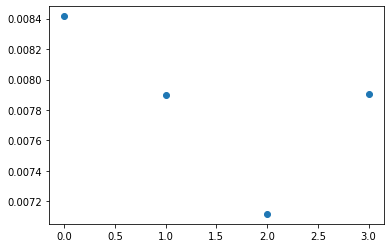

In [158]:
# Calculer la MSE entre les deux images
from skimage.metrics import mean_squared_error
mse_list = []
for idx in range(X_train.shape[0]) : 
    x_img = X_pred[idx,:,:]
    y_img = X_train[idx,:,:]
    mse = mean_squared_error(x_img, y_img)
    mse_list.append(mse)
    # Afficher la MSE
    print(' MSE for img', idx+1)
    print(mse)
plt.scatter(range(4),mse_list)